# Project 4: West Nile Virus Prediction


## Contents:
- [Data](#Data)
- [Model](#Model)



In [1]:
# Import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC

import warnings
warnings.filterwarnings('ignore')


# Data

**Data** 
* train_set.csv: this is the training dataset
* test_set.csv: this is the test dataset

In [2]:
train = pd.read_csv('../data/train_set.csv')

In [3]:
test = pd.read_csv('../data/test_set.csv')

In [4]:
# preview train set
train

,date,species_nr,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,trap_rank,tmax,tmin,...,avgspeed,temp_diff,week,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal
0,2007-05-29,1.0,41.688324,-87.676709,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
1,2007-05-29,1.0,41.720848,-87.666014,9,3,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
2,2007-05-29,1.0,41.731922,-87.677512,8,5,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
3,2007-05-29,1.0,41.732984,-87.649642,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
4,2007-05-29,1.0,41.862292,-87.648860,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,2013-09-26,3.0,41.960616,-87.777189,9,2,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8457,2013-09-26,3.0,41.964242,-87.757639,8,3,1,1,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8458,2013-09-26,3.0,41.973845,-87.805059,9,1,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8459,2013-09-26,3.0,41.974689,-87.890615,9,37,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0


In [5]:
train.shape

(8461, 31)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8461 entries, 0 to 8460
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8461 non-null   object 
 1   species_nr         8461 non-null   float64
 2   latitude           8461 non-null   float64
 3   longitude          8461 non-null   float64
 4   addressaccuracy    8461 non-null   int64  
 5   nummosquitos       8461 non-null   int64  
 6   wnvpresent         8461 non-null   int64  
 7   trap_rank          8461 non-null   int64  
 8   tmax               8461 non-null   float64
 9   tmin               8461 non-null   float64
 10  tavg               8461 non-null   float64
 11  depart             8461 non-null   float64
 12  dewpoint           8461 non-null   float64
 13  wetbulb            8461 non-null   float64
 14  sunrise            8461 non-null   float64
 15  sunset             8461 non-null   float64
 16  preciptotal        8461 

In [7]:
# change date to numerical
train['date'] = pd.to_datetime(train['date'])

In [8]:
# preview test set
test.head()

,id,date,latitude,longitude,addressaccuracy,species_nr,trap_rank,tmax,tmin,tavg,...,avgspeed,temp_diff,week,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal
0,1,2008-06-11,41.95469,-87.800991,9,2.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095
1,2,2008-06-11,41.95469,-87.800991,9,1.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095
2,3,2008-06-11,41.95469,-87.800991,9,3.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095
3,4,2008-06-11,41.95469,-87.800991,9,0.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095
4,5,2008-06-11,41.95469,-87.800991,9,0.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095


In [9]:
test.shape

(116293, 30)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 116293 non-null  int64  
 1   date               116293 non-null  object 
 2   latitude           116293 non-null  float64
 3   longitude          116293 non-null  float64
 4   addressaccuracy    116293 non-null  int64  
 5   species_nr         116293 non-null  float64
 6   trap_rank          116293 non-null  int64  
 7   tmax               116293 non-null  float64
 8   tmin               116293 non-null  float64
 9   tavg               116293 non-null  float64
 10  depart             116293 non-null  float64
 11  dewpoint           116293 non-null  float64
 12  wetbulb            116293 non-null  float64
 13  sunrise            116293 non-null  float64
 14  sunset             116293 non-null  float64
 15  preciptotal        116293 non-null  float64
 16  st

In [11]:
# change date to numerical
test['date'] = pd.to_datetime(test['date'])

In [12]:
# baseline score
train['wnvpresent'].value_counts()

0     8004
1      409
2       31
3        9
4        2
8        1
9        1
10       1
5        1
6        1
7        1
Name: wnvpresent, dtype: int64

In [13]:
# convert to binary
# 0 means no wnv detected
# 1 means wnv detected
def rebin_wnvpresent(row): 
    if row['wnvpresent'] > 0:
        row['wnvpresent'] = 1
    else:
        row['wnvpresent'] = 0
    return row

In [14]:
train = train.apply(rebin_wnvpresent,axis=1)

In [15]:
train['wnvpresent'].value_counts()

0    8004
1     457
Name: wnvpresent, dtype: int64

## Polynomial Features

Any of these features could be related to each other, or have an interactive effect with each other. Any synergistic effect on wnvpresent could increase the significant predictive power to the model. 

In [16]:
# 'nummosquitos' was removed from polynomial features because it is not a feature in the test set
# 'date' was removed as we extracted the 'week', 'year' from it.
X = train.drop(columns=['date','wnvpresent','nummosquitos'])
y = train['wnvpresent']

In [17]:
# Generating the polynomial features table.  
# instantiate
poly = PolynomialFeatures(include_bias=False, degree=2)

# fit and transform the variables in the numerical dataframe
X_poly = poly.fit_transform(X)
X_poly.shape

(8461, 434)

In [18]:
# Checking column names to all polynomial features
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names(X.columns))

# Generating list of poly feature correlations
X_poly_corrs = X_poly.corrwith(y)

# Shows top 40 features most positively correlated with wnvpresent
X_poly_corrs.sort_values(ascending=False).head(40)

addressaccuracy trap_rank      0.915657
latitude trap_rank             0.912398
trap_rank year                 0.912283
trap_rank                      0.912233
trap_rank sealevel             0.912162
trap_rank stnpressure          0.912148
trap_rank sunset               0.911941
trap_rank week                 0.910168
trap_rank sunrise              0.908579
trap_rank tavg                 0.907355
trap_rank tmin                 0.907185
trap_rank wetbulb              0.907144
trap_rank lag_2_tavg           0.906520
trap_rank tmax                 0.906483
trap_rank dewpoint             0.904773
trap_rank lag_1_tavg           0.904692
trap_rank avgspeed             0.871990
species_nr trap_rank           0.853837
trap_rank resultspeed          0.827764
trap_rank resultdir            0.821981
trap_rank temp_diff            0.792499
trap_rank^2                    0.579206
trap_rank depart               0.571068
trap_rank preciptotal          0.474681
trap_rank TS                   0.461440


The above showed that the highest correlation seemed to be location (trap_rank and addressaccuracy) related. From EDA, we already know that trap_rank has high correlation, and might not be necessary to add another feature related to trap_rank. In addition, nummosquitoes is not in the test set. So we think adding more features related to temperature such as 'species_nr dewpoint', 'tmin sunrise', 'wetbulb sunrise' would increase the predictive power of our model.

It is also important to note features that might have the highest negative impact on wnvpresent. The below list shows that longitude and sunset might have decrease/discourage the presence of wnvpresent. 

In [19]:
# Shows bottom 20 features most positively correlated with wnvpresent
X_poly_corrs.sort_values(ascending=False).tail(20) 

longitude TS           -0.056869
sunset year            -0.057391
sunset                 -0.059019
sunset stnpressure     -0.060200
sunset sealevel        -0.060779
longitude tmax         -0.061344
sunset^2               -0.061918
longitude depart       -0.065620
longitude              -0.076600
longitude FG           -0.077753
longitude temp_diff    -0.078773
longitude tavg         -0.079429
longitude year         -0.080058
longitude tmin         -0.090030
longitude wetbulb      -0.092972
longitude dewpoint     -0.095661
longitude sunrise      -0.098397
longitude week         -0.101082
species_nr longitude   -0.125671
longitude trap_rank    -0.912227
dtype: float64

In [20]:
# Adding interaction features into train set
train['species_nr*dewpoint'] = train['species_nr'] * train['dewpoint']
train['tmin*sunrise'] = train['tmin'] * train['sunrise']
train['wetbulb*sunrise'] = train['wetbulb'] * train['sunrise']


In [21]:
# final train set
train.head()

,date,species_nr,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,trap_rank,tmax,tmin,...,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal,species_nr*dewpoint,tmin*sunrise,wetbulb*sunrise
0,2007-05-29,1.0,41.688324,-87.676709,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
1,2007-05-29,1.0,41.720848,-87.666014,9,3,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
2,2007-05-29,1.0,41.731922,-87.677512,8,5,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
3,2007-05-29,1.0,41.732984,-87.649642,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
4,2007-05-29,1.0,41.862292,-87.648860,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5


In [22]:
# Adding interaction features into test set
test['species_nr*dewpoint'] = test['species_nr'] * test['dewpoint']
test['tmin*sunrise'] = test['tmin'] * test['sunrise']
test['wetbulb*sunrise'] = test['wetbulb'] * test['sunrise']


# Model

## Baseline model (with SMOTE)

Let's just start with modeling using one feature. Since 'trap_rank', 'species_nr' has the largest correlation to 'wnvpresent', the feature will be used. Simplest classification method would be the logistic regression model. 

In [23]:
X_sm = train[['species_nr']]
y_sm = train[['wnvpresent']]

In [24]:
# split data
Xsm_train, Xsm_valid, ysm_train, ysm_valid = train_test_split(X_sm, y_sm, test_size = 0.33, random_state = 42, stratify =y)

In [25]:
# scaling
ss = StandardScaler()

Xsm_train_sc = ss.fit_transform(Xsm_train)
Xsm_valid_sc = ss.transform(Xsm_valid)

In [26]:
# instantiate
lr = LogisticRegression()

# fit model
lr.fit(Xsm_train_sc, ysm_train)

# score
lr.score(Xsm_train_sc, ysm_train), lr.score(Xsm_valid_sc, ysm_valid)

(0.9460127028934369, 0.9459362692445399)

In [27]:
ysm_train.value_counts()

wnvpresent
0             5362
1              306
dtype: int64

Using only one feature, regardless which one feature, would result in high R2 score. This is because the predictive feature is imbalanced in the training set.

**with SMOTE**

In [28]:
# create synthetic data for training set

smote = SMOTE()

Xsmote_train, ysmote_train = smote.fit_sample(Xsm_train_sc, ysm_train)

In [29]:
ysmote_train.value_counts()

wnvpresent
0             5362
1             5362
dtype: int64

Now, the predictive feature is more balanced.

In [30]:
# instantiate
lr2 = LogisticRegression()

# fit model
lr2.fit(Xsmote_train, ysmote_train)

# score
lr2.score(Xsmote_train, ysmote_train), lr2.score(Xsm_valid_sc, ysm_valid)

(0.5991234613950018, 0.7608306480486932)

### Logistic regression model (with SMOTE)

In [31]:
# columns of train with polynomial features
train

,date,species_nr,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,trap_rank,tmax,tmin,...,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal,species_nr*dewpoint,tmin*sunrise,wetbulb*sunrise
0,2007-05-29,1.0,41.688324,-87.676709,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
1,2007-05-29,1.0,41.720848,-87.666014,9,3,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
2,2007-05-29,1.0,41.731922,-87.677512,8,5,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
3,2007-05-29,1.0,41.732984,-87.649642,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
4,2007-05-29,1.0,41.862292,-87.648860,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,2013-09-26,3.0,41.960616,-87.777189,9,2,0,0,75.0,52.5,...,2013.0,0.0,0.0,70.00,61.50,0.460,0.0,156.0,28507.5,31494.0
8457,2013-09-26,3.0,41.964242,-87.757639,8,3,1,1,75.0,52.5,...,2013.0,0.0,0.0,70.00,61.50,0.460,0.0,156.0,28507.5,31494.0
8458,2013-09-26,3.0,41.973845,-87.805059,9,1,0,0,75.0,52.5,...,2013.0,0.0,0.0,70.00,61.50,0.460,0.0,156.0,28507.5,31494.0
8459,2013-09-26,3.0,41.974689,-87.890615,9,37,0,0,75.0,52.5,...,2013.0,0.0,0.0,70.00,61.50,0.460,0.0,156.0,28507.5,31494.0


In [32]:
X = train.drop(columns=['date','wnvpresent','nummosquitos'])
y = train[['wnvpresent']]

In [33]:
# split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify =y)

In [34]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('logreg', LogisticRegression(max_iter=1_000, solver='saga'))
    ])

In [35]:
# regardless of parameters, there is overfitting.
pipe_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [250],   # tried 1-10000
    'logreg__penalty': ['l2', 'l1'],   # tried 'l2', 'l1', 'elastinet'
    'logreg__C': [1] # tried 1-20
}

In [36]:
grid = GridSearchCV(pipe, pipe_params, scoring='roc_auc', n_jobs=-1)

In [37]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1], 'logreg__penalty': ['l2', 'l1'],
                         'sampling__k_neighbors': [250],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc')

In [38]:
grid.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l2',
 'sampling__k_neighbors': 250,
 'sampling__sampling_strategy': 'not minority'}

In [39]:
grid.score(X_train, y_train), grid.score(X_valid, y_valid)

(0.9999744022935545, 1.0)

Regardless of pipe_params used, there is overfitting. There is a lot of multicollinearity, and features have to be dropped before modeling.

Since there might be too many variables with high multicollinearity, we need to reduce number of features and/or utilise PCA to transform the data first. In such a case, we can use PCA to identify and keep those potential important relationships, before performing the predictions/models. 

## Feature reduction

In [40]:
traincorr = train.corr().abs()
traincorr.loc[traincorr['wnvpresent']>=0.05,['wnvpresent']].sort_values(by=['wnvpresent'],ascending=False)

,wnvpresent
wnvpresent,1.000000
trap_rank,0.912233
nummosquitos,0.233468
species_nr*dewpoint,0.150687
tmin*sunrise,0.148456
wetbulb*sunrise,0.147635
species_nr,0.125474
week,0.100530
sunrise,0.097607
dewpoint,0.095074


In [41]:
# drop tmin tmax longitude nummosquitos 

Due to multicollinearity, tmin and tmax will be dropped, inplace of tavg. nummosquitoes will be dropped because it is not in test set. 

In [42]:
X = train.drop(columns=['date','wnvpresent','nummosquitos'])
y = train[['wnvpresent']]

In [43]:
# split again, just to make sure
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify =y)

# scaling
ss_pca = StandardScaler()

X_train_sc = ss_pca.fit_transform(X_train)
X_valid_sc = ss_pca.transform(X_valid)

## Feature extraction 


### Exploring PCA-transformed data

Due to the number of features (and high-dimensional manifold) in our dataset, PCA was utilised to perform an unsupervised dimensionality reduction on the training dataset. In such a way, PCA will provide the best linear approximations before modeling and prediction was performed ([source](https://arxiv.org/ftp/arxiv/papers/1403/1403.1949.pdf)). GridSearchCV is used to set the dimensionality of the PCA. 

In [44]:
X = train.drop(columns=['date','wnvpresent','nummosquitos'])
y = train[['wnvpresent']]

In [45]:
X.shape

(8461, 31)

In [46]:
# split again, just to make sure
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify =y)

# scaling
ss_pca = StandardScaler()

X_train_sc = ss_pca.fit_transform(X_train)
X_valid_sc = ss_pca.transform(X_valid)

In [47]:
# Instantiate PCA.
# up to n_components were tested
pca = PCA(n_components = 10)

# Fit PCA on the training data.
pca.fit(X_train_sc)

PCA(n_components=10)

In the below pipeline, PCA will perform unsupervised dimensionality reduction on the training data before upsampling it. This is so that upsampling will only be performed on the reduced dimensional manifold and not on the entire dataset. The models for the prediction will be done last. In the below pipeline, the logistic regression model was utilised. 

In [48]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA()),
        ('sampling', SMOTE()),
        ('logreg', LogisticRegression(max_iter=1_000, solver='saga'))
    ])

In [49]:
pipe_params = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  
} 

In [50]:
grid = GridSearchCV(pipe, pipe_params, scoring='roc_auc', n_jobs=-1)

In [51]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA()), ('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

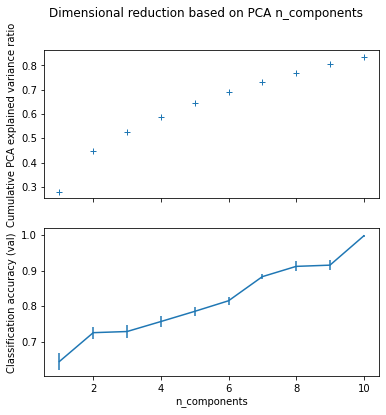

In [52]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py
# Plot search for best combination of PCA n_components and logistic regression accuracy
# pca.fit(X_train_sc)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(), '+', linewidth=10)
ax0.set_ylabel('Cumulative PCA explained variance ratio')

results = pd.DataFrame(grid.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components');
plt.suptitle('Dimensional reduction based on PCA n_components');

In [53]:
print(f'Cumulative explained variance (for n_components=9): {pca.explained_variance_ratio_.cumsum()[9]}')

Cumulative explained variance (for n_components=9): 0.8350762447402491


In [54]:
grid.best_params_

{'pca__n_components': 10}

In [55]:
grid.score(X_train, y_train), grid.score(X_valid, y_valid)

(0.9998732304061746, 1.0)

GridSearchCV chose n_components=10, however, there was overfitting at n_components=10. Since PCA utilises n_components, the decision is to use n_components=9, to minimise overfitting, and we would retain approximately 83% of the variability in the data.

In [56]:
# high auc and low recall is not ideal. 
# 0.1 difference between train and holdout

### Loop models

In [57]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=1000, solver='saga'),
        'dt': DecisionTreeClassifier(),
        'rf': RandomForestClassifier(),
        'et': ExtraTreesClassifier(),
        'svc': SVC(probability=True),
        } 

In [58]:
def run_models(model, model_params):
    pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components = 9)),
            ('sampling', SMOTE()),
            (model, models[model])
            ])
    
    grid = GridSearchCV(pipe, param_grid=model_params, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    # metrics
    train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_valid, y_valid)
    preds = grid.predict(X_valid)
    tn, fp, fn, tp = confusion_matrix(y_valid, preds).ravel()

#     y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
#     y_valid_pred_prob = pipe.predict_proba(X_valid)[:,1]
#     train_auc = roc_auc_score(y_train, y_train_pred_prob)
#     valid_auc = roc_auc_score(y_valid, y_valid_pred_prob)
    
    # View confusion matrix
    plot_confusion_matrix(grid, X_valid, y_valid, cmap='Blues', values_format='d');
    
    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)
    
    # Calculate the specificity
    spec = tn / (tn + fp) 
    
    # print results
    print(f'Best params: {grid.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'recall: {round(sens, 4)}')
    print(f'specificity: {round(spec, 4)}')
    return grid

**Logistic Regression**

Best params: {'lr__C': 1, 'lr__penalty': 'l1', 'sampling__k_neighbors': 200, 'sampling__sampling_strategy': 'minority'}
Training score: 0.9178
Test score: 0.9322
recall: 0.8278
specificity: 0.8569


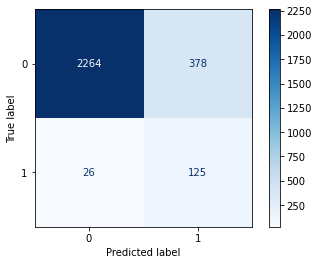

In [79]:
# logistic regression
grid_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [150, 200, 250],  # recall < 1 above 250
    'lr__penalty': ['l1', 'l2',  'elasticnet'],   
    'lr__C': [0.1, 1, 10]  
} 

best_params = {
    'sampling__sampling_strategy': ['minority'],
    'sampling__k_neighbors': [200],  
    'lr__penalty': ['l1'],   
    'lr__C': [1]  
}

lr = run_models('lr', best_params)
# Best params: {'lr__C': 1, 'lr__penalty': 'l1', 'sampling__k_neighbors': 200, 'sampling__sampling_strategy': 'minority'}

There was little change in tuning the hyperparameters for the logistic regression. There might be an issue with underfitting, since training score > test score. However, it is uncertain (for now) if one of the ways to combat this is to decrease or increase the sampling strategy, since recall was affected, despite having good training and test scores. 'saga' was selected as the 'solver' since it supports several penalties. 'none' was not provided as an option due to tendency of getting training scores = 1.0. So applying regularisation did help to minimise overfitting.

**Decision Tree Classifier**

Best params: {'dt__max_depth': 500, 'dt__min_samples_leaf': 150, 'dt__min_samples_split': 100, 'sampling__k_neighbors': 150, 'sampling__sampling_strategy': 'auto'}
Training score: 0.9608
Test score: 0.9408
recall: 0.8344
specificity: 0.9338


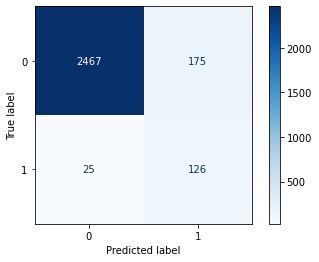

In [60]:
# decision tree classifier
grid_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [150, 200, 250],  # overfitting below 250
    'dt__max_depth': [400, 450, 500],
    'dt__min_samples_split': [100, 150, 200],
    'dt__min_samples_leaf': [100, 150, 200],
} 

best_params = {
    'sampling__sampling_strategy': ['auto'],
    'sampling__k_neighbors': [150],  
    'dt__max_depth': [500],
    'dt__min_samples_split': [100],
    'dt__min_samples_leaf': [150],
} 

dt = run_models('dt', best_params)
# Best params: {'dt__max_depth': 500, 'dt__min_samples_leaf': 100, 'dt__min_samples_split': 150, 'sampling__k_neighbors': 150, 'sampling__sampling_strategy': 'auto'}

I do not understand the popularity of decision trees, due to its tendency to overfit, and efforts spent on tuning the parameters to ensure that training score=1.0 does not occur. The hyperparameters are relatively higher (than what I had previously seen), but this was due to training score = 0.999. 'max_depth' is the maximum depth of the tree, where default=None. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. Since GridSearchCV chooses the estimator based on the highest score, one will have to provide restricted ranges such that training score = 0.999 does not occur. In most parts during hyperparameter selection, there was a balance between providing certain values for GridSearch to tune, such that the higher value of maximum depth does not result in overfitting, and a lower value does not result in underfitting. 

**Random forest classifier**

Best params: {'rf__max_depth': 500, 'rf__min_samples_leaf': 100, 'rf__min_samples_split': 200, 'rf__n_estimators': 350, 'sampling__k_neighbors': 200, 'sampling__sampling_strategy': 'auto'}
Training score: 0.9798
Test score: 0.9613
recall: 0.8411
specificity: 0.9466


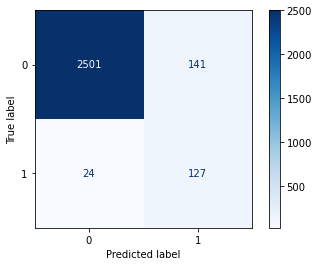

In [61]:
# random forest classifier
grid_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [150, 200, 250], 
    'rf__n_estimators': [300, 350, 400],
    'rf__max_depth': [400, 450, 500],
    'rf__min_samples_split': [100, 150, 200],
    'rf__min_samples_leaf': [100, 150, 200],
} 

best_params = {
    'sampling__sampling_strategy': ['auto'],
    'sampling__k_neighbors': [200], 
    'rf__n_estimators': [350],
    'rf__max_depth': [500],
    'rf__min_samples_split': [200],
    'rf__min_samples_leaf': [100],
} 

rf = run_models('rf', best_params)
# Best params: {'rf__max_depth': 500, 'rf__min_samples_leaf': 100, 'rf__min_samples_split': 200, 'rf__n_estimators': 350, 'sampling__k_neighbors': 200, 'sampling__sampling_strategy': 'auto'}

Similarly to decision tress (and not totally unexpected), the hyperparameters were relatively higher, but this was due to training score = 0.999. Also (and not totally unexpected), pre-pruning to stop GridSearchCV from growing/cutting down trees was necessary to prevent overfitting. Increasing 'min_samples_leaf' and 'min_samples_split' were essential to ensure that the classifier does not keep splitting the dataset to be more 'pure'. However, there seems to be less issue with recall and specificity in the decision tree and random forests classifiers, compared to logistic regression.

**Extra trees classifier**

Best params: {'et__max_depth': 450, 'et__min_samples_leaf': 100, 'et__min_samples_split': 150, 'et__n_estimators': 300, 'sampling__k_neighbors': 200, 'sampling__sampling_strategy': 'minority'}
Training score: 0.9646
Test score: 0.9553
recall: 0.8477
specificity: 0.908


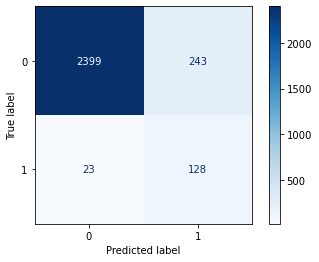

In [62]:
# extra trees classifier
grid_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [150, 200, 250],
    'et__n_estimators': [300, 350],
    'et__max_depth': [400, 450],
    'et__min_samples_split': [100, 150],
    'et__min_samples_leaf': [100, 150],
} 

best_params = {
    'sampling__sampling_strategy': ['minority'],
    'sampling__k_neighbors': [200],
    'et__n_estimators': [300],
    'et__max_depth': [450],
    'et__min_samples_split': [150],
    'et__min_samples_leaf': [100],
}

et = run_models('et', best_params)
# Best params: {'et__max_depth': 450, 'et__min_samples_leaf': 100, 'et__min_samples_split': 150, 'et__n_estimators': 300, 'sampling__k_neighbors': 200, 'sampling__sampling_strategy': 'minority'}

**Support Vector Classification**

Best params: {'sampling__k_neighbors': 300, 'sampling__sampling_strategy': 'not minority', 'svc__C': 5, 'svc__kernel': 'rbf'}
Training score: 0.9813
Test score: 0.9751
recall: 0.9139
specificity: 1.0


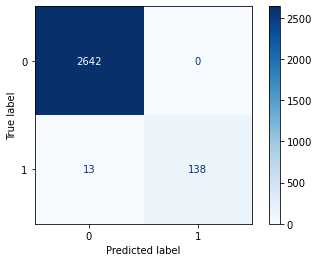

In [63]:
# Support Vector Classification
grid_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [250, 300],     # <200 overfitting
    'svc__kernel': ['linear', 'poly', 'rbf'],    
    'svc__C': [1 ,3 ,5] 
} 

best_params = {
    'sampling__sampling_strategy': ['not minority'],
    'sampling__k_neighbors': [300],     # <200 overfitting
    'svc__kernel': ['rbf'],    
    'svc__C': [5] 
} 

svc = run_models('svc', best_params)
# Best params: {'sampling__k_neighbors': 300, 'sampling__sampling_strategy': 'not minority', 'svc__C': 20, 'svc__kernel': 'rbf'}

### Plot ROC-AUC 

In [64]:
def plot_all_auc(models):
    fig, ax = plt.subplots(figsize=(10,10))
    axes = {}
    for i, m in enumerate(models.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_valid, y_valid, ax=ax, name=models[m])
        
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.title('ROC-AUC curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()

In [65]:
models_built = {
    lr : 'LogisticRegression', 
    dt : 'DecisionTreeClassifier',
    rf : 'RandomForestClassifier',
    et : 'ExtraTreesClassifier',
    svc : 'SVC',
} 

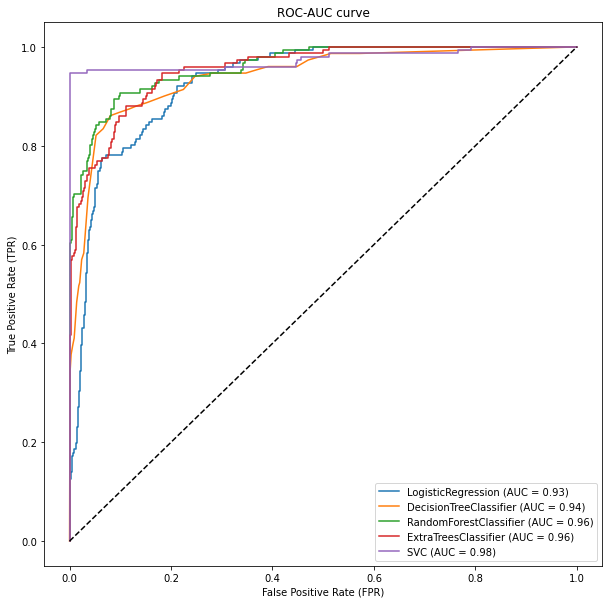

In [66]:
plot_all_auc(models_built)

From the above ROC-AUC curve, the SVC model has the highest AUC score, ie., it is better at predicting classes or distinguishing between the classes. So the SVC model also presents the best performing trade-off between the true positives and true negatives. In addition, SVC model has good recall rate at 0.91. Therefore, using PCA-transformed data, **the SVC model was selected as the chosen model.**
<br>
<br> At FPR=1, where sensitivity is the highest, all classifiers seemed to performed well till FPR=0.8. Below this point, the decision tree (dt) classifier starts to exhibit lower sensitivity, with the lowest sensitivity reported among all the models. Given the tendency for dt to overfit, the parameters were tuned that a training score = 0.999 did not occur. 
<br> 
<br> At FPR=0, where specificity is the highest, the sudden decrease in logistic regression showed that the model has the lowest specificity. 

## Kaggle predictions using test set

In [67]:
test.head()

,id,date,latitude,longitude,addressaccuracy,species_nr,trap_rank,tmax,tmin,tavg,...,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal,species_nr*dewpoint,tmin*sunrise,wetbulb*sunrise
0,1,2008-06-11,41.95469,-87.800991,9,2.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,111.0,26416.0,26624.0
1,2,2008-06-11,41.95469,-87.800991,9,1.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,55.5,26416.0,26624.0
2,3,2008-06-11,41.95469,-87.800991,9,3.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,166.5,26416.0,26624.0
3,4,2008-06-11,41.95469,-87.800991,9,0.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,0.0,26416.0,26624.0
4,5,2008-06-11,41.95469,-87.800991,9,0.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,0.0,26416.0,26624.0


In [68]:
# drop columns
X_test = test.drop(columns=['id','date'])

# check that shape is same to train dataset
X_test.shape

(116293, 31)

In [69]:
def run_test(model, model_params):
    pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components = 9)),
            ('sampling', SMOTE()),
            (model, models[model])
            ])
    
    grid = GridSearchCV(pipe, param_grid=model_params, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    train_score = grid.score(X_train, y_train)
#     preds = grid.predict(X_test)
    pred_prob = grid.predict_proba(X_test)
    
    print(f'Training score: {round(train_score, 4)}')
    return pred_prob

In [70]:
# Support Vector Classification
best_params = {
    'sampling__sampling_strategy': ['not minority'],
    'sampling__k_neighbors': [150],    
    'svc__kernel': ['rbf'],    
    'svc__C': [1] #5
} 

y_pred = run_test('svc', best_params)

Training score: 0.9532


In [71]:
# y
kaggle_y = test[['id']]
kaggle_y['wnvpresent'] = pd.DataFrame(y_pred[:,1])

**Save predicted results as csv file for kaggle submission.**

In [72]:
kaggle_y.to_csv('../data/kaggle_y.csv',index=False)